In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import matplotlib
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Constants and parameters
N_GRID_X = 100
N_GRID_Y = 100
N_CONTOUR_LEVELS = 12
MAKE_EIGENVECTOR_EXAMPLE_PLOT = False

cmap = make_cmap.make_cmap("w_ymiddle1.xml")
# cmap = cmap.reversed()

In [4]:
def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def make_eigenvector_example_plot():
    n_eigenvalues = 110
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        n_eigenvalues, meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid
    )

    # Plot select eigenmodes
    plt.figure(figsize=(16, 13))

    for i in range(0, 18):
        ax = plt.subplot(3, 6, i + 1)

        # Shift eigenmodes by plotting row to show some dynamic range
        if i > 5 and i <= 11:
            i = i - 6 + 30
        elif i > 11:
            i = i - 12 + 100
        fill_value = fill_value = eigenvectors[:, i]

        # Normalize fill_value for interpretable plotting
        min_value = np.min(fill_value)
        max_value = np.max(fill_value)
        if np.abs(max_value) > np.abs(min_value):
            fill_value = fill_value / max_value
        else:
            fill_value = fill_value / np.abs(min_value)

        if i == 0 and np.nanmean(fill_value) < 0:
            fill_value = -1 * fill_value

        interpolate_and_plot(fill_value)
        plt.title(f"mode {i}")

    plt.savefig("eigenvector_examples.pdf")
    plt.savefig("eigenvector_examples.png", dpi=500)
    plt.show()


def get_synthetic_displacements_test(mesh, sources, tde_matrix, observation_noise):
    n_vels = tde_matrix.shape[0]
    slip_distribution = np.zeros(2 * mesh.n_tde)
    strike_slip_distribution = np.zeros(mesh.n_tde)
    dip_slip_distribution = np.zeros(mesh.n_tde)

    for i in range(sources.lon.size):
        source_to_mesh_centroid_lon = mesh.centroids[:, 0] - sources.lon[i]
        source_to_mesh_centroid_lat = mesh.centroids[:, 1] - sources.lat[i]

        source_to_mesh_centroid_distance = np.sqrt(
            source_to_mesh_centroid_lon**2.0 + source_to_mesh_centroid_lat**2.0
        )

        # Guassian slip pattern
        if sources.slip_type[i] == "strike_slip":
            strike_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )
        elif sources.slip_type[i] == "dip_slip":
            dip_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )

    slip_distribution[0::2] = strike_slip_distribution  # Strike slip only
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only

    # Adding a teeny amount of non-zero noise here just so contouring works
    # TODO: Move this to plotting routine
    slip_distribution[0::2] += 1e-4 * np.random.randn(mesh.n_tde)
    slip_distribution[1::2] += 1e-4 * np.random.randn(mesh.n_tde)

    # Forward calculation of synthetic displacments
    synthetic_displacements = tde_matrix @ slip_distribution

    # Add noise to synthetic displacments
    synthetic_displacements += observation_noise * np.random.randn(n_vels)

    return slip_distribution, synthetic_displacements


In [5]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-09-04 21:25:31.063 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-09-04 21:25:31.063 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-09-04-21-25-31
2022-09-04 21:25:31.064 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-09-04-21-25-31/2022-09-04-21-25-31.log
2022-09-04 21:25:31.064 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-09-04 21:25:31.070 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-09-04 21:25:31.072 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-09-04 21:25:31.072 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-09-04 21:25:31.099 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-09-04 21:25:31.102 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-09-04 21:25:31.103 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-09-04 21:25:31.104 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


In [6]:
# Create example figure with select eigenvectors
if MAKE_EIGENVECTOR_EXAMPLE_PLOT:
    make_eigenvector_example_plot()

In [7]:
operators = addict.Dict()
operators.tde_matrix = celeri.get_tde_to_velocities(meshes, station, command)
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(operators.tde_matrix)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

# Generate synthetic slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(
    meshes[0], tde_matrix
)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]


Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:16<00:00, 110.36it/s]


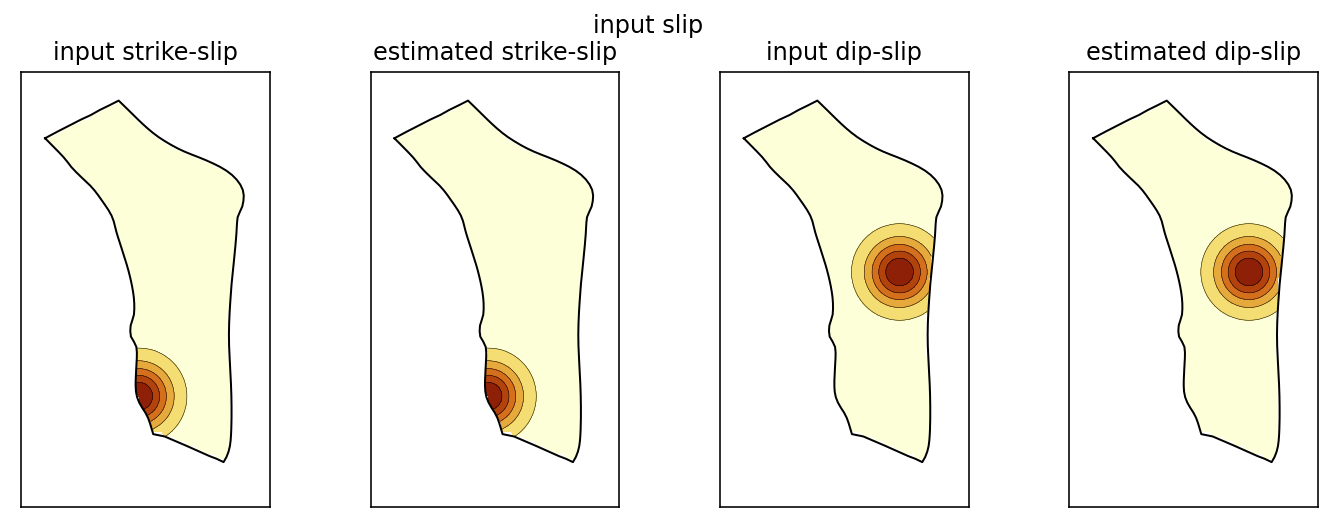

In [8]:
# Define input slip distributions and noisy data

# Cascadia example
sources = addict.Dict()
sources.lon = np.array([236.779, 234.779])
sources.lat = np.array([45.553, 41.553])
sources.magnitude = np.array([1.0, 1.0])
sources.slip_type = ["dip_slip", "strike_slip"]
observation_noise = 0.01

slip_distribution, synthetic_displacements = get_synthetic_displacements_test(
    meshes[0], sources, tde_matrix, observation_noise
)

plot_slip_distributions(
    slip_distribution,
    slip_distribution,
    suptitle_string=f"input slip",
)


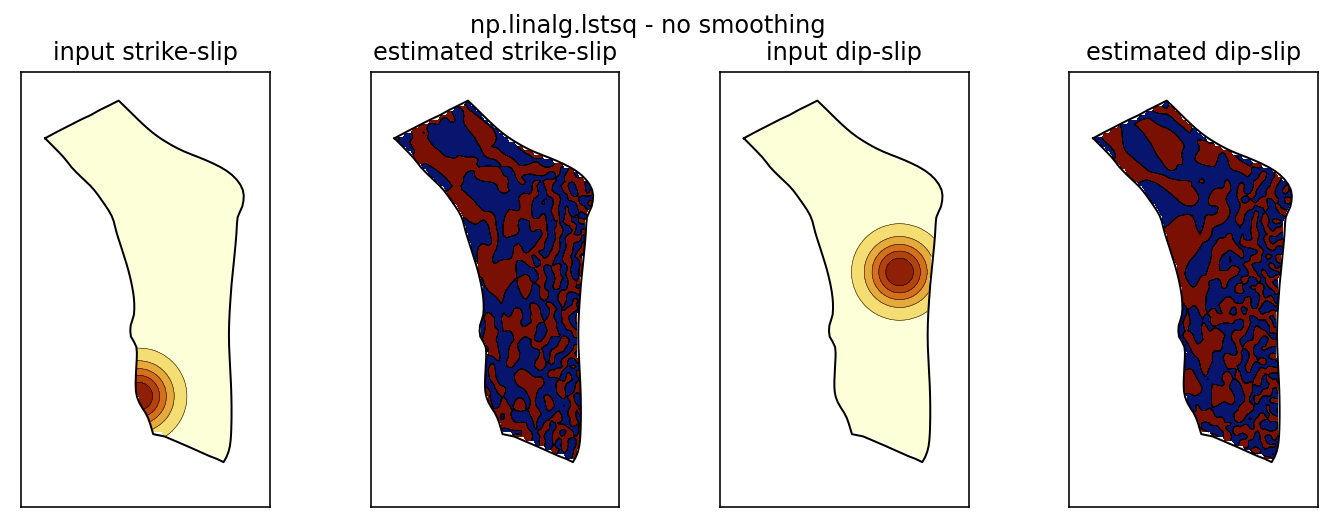

CPU times: user 1min 7s, sys: 9.54 s, total: 1min 17s
Wall time: 17 s


In [9]:
%%time
# Direct least squares estimate with no smoothing
slip_distribution_estimated = np.linalg.lstsq(
    tde_matrix, synthetic_displacements, rcond=None
)

plot_slip_distributions(
    slip_distribution,
    slip_distribution_estimated[0],
    suptitle_string="np.linalg.lstsq - no smoothing",
)


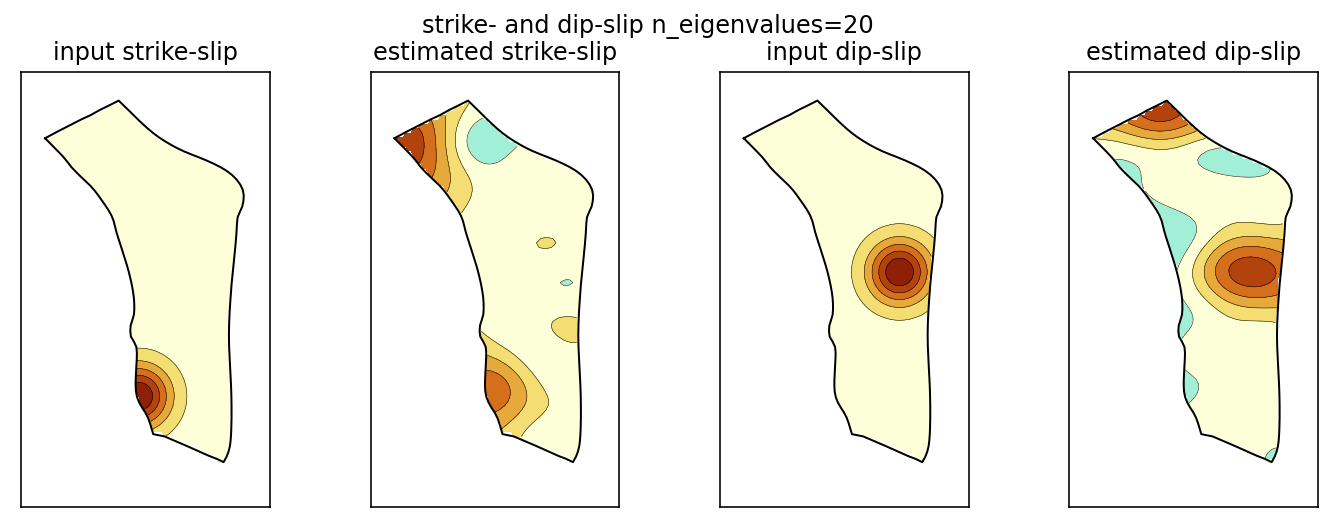

Memory size in MB: 1.07904
CPU times: user 6.28 s, sys: 2.64 s, total: 8.93 s
Wall time: 2.1 s


In [10]:
%%time
# Eigenvalue slip estimate with strike- and dip-slip
n_eigenvalues = 20
eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    n_eigenvalues, meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid
)

# Create modified eigenvector matrix here
eigenvectors_two_component = np.zeros((2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1]))
for i in range(n_eigenvalues):
    index_column_1 = 2 * i
    index_column_2 = 2 * i + 1
    eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
    eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]
    
# Solve for eigenvector weights
eigenvector_weights_estimated = (
    np.linalg.pinv(tde_matrix @ eigenvectors_two_component) @ synthetic_displacements
)

# Recover slip from eigenvector weights
slip_distribution_estimated_two_component = (
    eigenvectors_two_component @ eigenvector_weights_estimated
)

plot_slip_distributions(
    slip_distribution,
    slip_distribution_estimated_two_component,
    suptitle_string=f"strike- and dip-slip {n_eigenvalues=}",
)

print("Memory size in MB:",
      (tde_matrix @ eigenvectors_two_component).size * (tde_matrix @ eigenvectors_two_component).itemsize * 1e-6) 


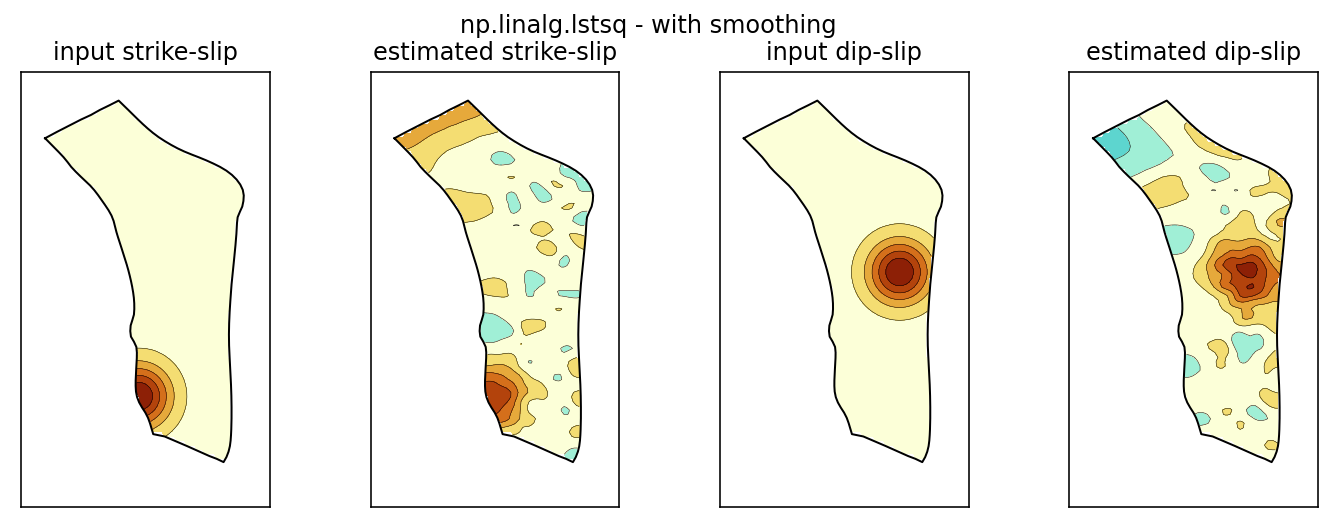

Memory size in MB: 207.782624
CPU times: user 1min 46s, sys: 12.2 s, total: 1min 58s
Wall time: 22.9 s


In [11]:
%%time
# Smoothed least squares
smoothing_weight = 1e7
smoothing_matrix = operators.smoothing_matrix[0].todense()
smoothing_matrix = np.delete(smoothing_matrix, np.arange(2, smoothing_matrix.shape[0], 3), axis=0)
smoothing_matrix = np.delete(smoothing_matrix, np.arange(2, smoothing_matrix.shape[1], 3), axis=1)
tde_matrix_smoothing_augmented = np.vstack((tde_matrix, smoothing_weight * smoothing_matrix))
synthetic_displacements_smoothing_augmented = np.hstack((synthetic_displacements, np.zeros(tde_matrix.shape[1])))

# Direct least squares estimate with no smoothing
slip_distribution_estimated = np.linalg.lstsq(
    tde_matrix_smoothing_augmented, synthetic_displacements_smoothing_augmented, rcond=None
)

plot_slip_distributions(
    slip_distribution,
    slip_distribution_estimated[0],
    suptitle_string="np.linalg.lstsq - with smoothing",
)

print("Memory size in MB:", tde_matrix_smoothing_augmented.size * tde_matrix_smoothing_augmented.itemsize * 1e-6) 
